# IMU only training notebook

### 1: import IMU-only data

In [1]:
# import variables
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Masking, BatchNormalization, LSTM, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# scaled data
train_IMU_scaled = np.load('../input/cmi-ocd-variables/variables/train_IMU_scaled.npy')
test_IMU_scaled = np.load('../input/cmi-ocd-variables/variables/test_IMU_scaled.npy')
val_IMU_scaled = np.load('../input/cmi-ocd-variables/variables/val_IMU_scaled.npy')

# unscaled data
train_IMU_prescaled = pd.read_csv('../input/cmi-ocd-variables/variables/train_IMU_prescaled.csv')
test_IMU_prescaled = pd.read_csv('../input/cmi-ocd-variables/variables/test_IMU_prescaled.csv')
val_IMU_prescaled = pd.read_csv('../input/cmi-ocd-variables/variables/val_IMU_prescaled.csv')

2025-11-29 00:45:27.037721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764377127.277831      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764377127.336187      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# list feature names for train and test
print("Training/Validation features:")
print(train_IMU_prescaled.columns.to_list())
print("\nTest features:")
print(test_IMU_prescaled.columns.to_list())

Training/Validation features:
['sequence_id', 'gesture', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z']

Test features:
['sequence_id', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z']


### 2: sequence data

In [3]:
train_IMU_prescaled = train_IMU_prescaled.reset_index(drop=True)
test_IMU_prescaled = test_IMU_prescaled.reset_index(drop=True)
val_IMU_prescaled = val_IMU_prescaled.reset_index(drop=True)

# sequence train data
grouped_train = train_IMU_prescaled.groupby('sequence_id')
sequences_train = []
labels_train = []
for sequence_id, group in grouped_train:
    indices_train = group.index.to_list()
    current_sequence_data = train_IMU_scaled[indices_train]
    features_only = np.delete(current_sequence_data, 1, axis=1)
    sequences_train.append(features_only)
    label_train = group['gesture'].iloc[0]
    labels_train.append(label_train)

# sequence test data
grouped_test = test_IMU_prescaled.groupby('sequence_id')
sequences_test = []
for sequence_id, group in grouped_test:
    indices_test = group.index.to_list()
    current_sequence = test_IMU_scaled[indices_test]
    sequences_test.append(current_sequence)

# sequence val data
grouped_val = val_IMU_prescaled.groupby('sequence_id')
sequences_val = []
labels_val = []
for sequence_id, group in grouped_val:
    indices_val = group.index.to_list()
    current_sequence_data = val_IMU_scaled[indices_val]
    features_only = np.delete(current_sequence_data, 1, axis=1)
    sequences_val.append(features_only)
    
    label_val = group['gesture'].iloc[0]
    labels_val.append(label_val)

In [4]:
# pad data
def pad_data(sequences, max_length=None):
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32', maxlen=700)
    return padded_sequences

train_padded = pad_data(sequences_train)
test_padded = pad_data(sequences_test)
val_padded = pad_data(sequences_val)

y_train = np.array(labels_train)
y_val = np.array(labels_val)

print("Shape of the final padded data:", train_padded.shape) 
print("Shape of the final padded data:", test_padded.shape) 
print("Shape of the final padded data:", val_padded.shape) 

Shape of the final padded data: (6336, 700, 12)
Shape of the final padded data: (2, 700, 12)
Shape of the final padded data: (1584, 700, 12)


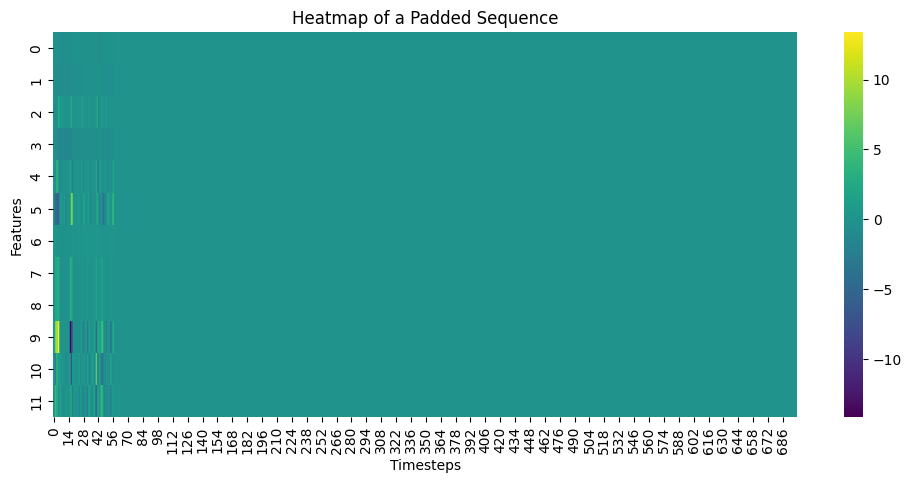

In [5]:
# select a sample to view (the first one)
sample_to_view = train_padded[0]

# create the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(sample_to_view.T, cmap='viridis')
plt.title('Heatmap of a Padded Sequence')
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()

# Dummy Classifier

In [6]:
dummy_clf = DummyClassifier(strategy="most_frequent")

# initialize and fit encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

dummy_clf.fit(train_padded, y_train)

# predict on the validation set
y_val_pred_dummy = dummy_clf.predict(val_padded)

# calculate baseline accuracy
baseline_accuracy = accuracy_score(y_val, y_val_pred_dummy)
print(f"Baseline (Most Frequent) Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline (Most Frequent) Accuracy: 7.45%


In [7]:
# set variables
num_timesteps = 700 
num_features = 12
num_classes = 18

# define model
model = Sequential([
    # block 1 
    Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.001), input_shape=(num_timesteps, num_features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 2 
    Conv1D(filters=256, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 3
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 4
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 5
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalMaxPooling1D(),  # Alternative to MaxPooling1D + Flatten
    Dropout(0.4),
    
    # dense layers
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# compile model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764377147.383875      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764377147.384530      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 694, 128)       │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 694, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 343, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 343, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 169, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 169, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 82, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 82, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 39, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             

 Total params: 1,988,370 (7.59 MB)

 Trainable params: 1,985,042 (7.57 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [8]:
# re-encode and re-define as new variables
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

print("Labels successfully encoded.")

Labels successfully encoded.


Training model...
Epoch 1/200


I0000 00:00:1764377156.673253      64 service.cc:148] XLA service 0x7f4b2c00d0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764377156.674081      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764377156.674102      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764377157.455300      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/198 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.0996 - loss: 12.7428

I0000 00:00:1764377165.833047      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.0778 - loss: 7.2220 - val_accuracy: 0.0878 - val_loss: 5.0860 - learning_rate: 0.0010
Epoch 2/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.0906 - loss: 5.0811 - val_accuracy: 0.1345 - val_loss: 4.8251 - learning_rate: 0.0010
Epoch 3/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1138 - loss: 4.8341 - val_accuracy: 0.1692 - val_loss: 4.5626 - learning_rate: 0.0010
Epoch 4/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1389 - loss: 4.5516 - val_accuracy: 0.1534 - val_loss: 4.3482 - learning_rate: 0.0010
Epoch 5/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1598 - loss: 4.3139 - val_accuracy: 0.1673 - val_loss: 4.1399 - learning_rate: 0.0010
Epoch 6/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1845 - loss: 4.0775 - val_accuracy: 0.1831 - val_loss: 3.9324 - learning_rate: 0.0010
Epoch 7/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1897 - loss: 3.8580

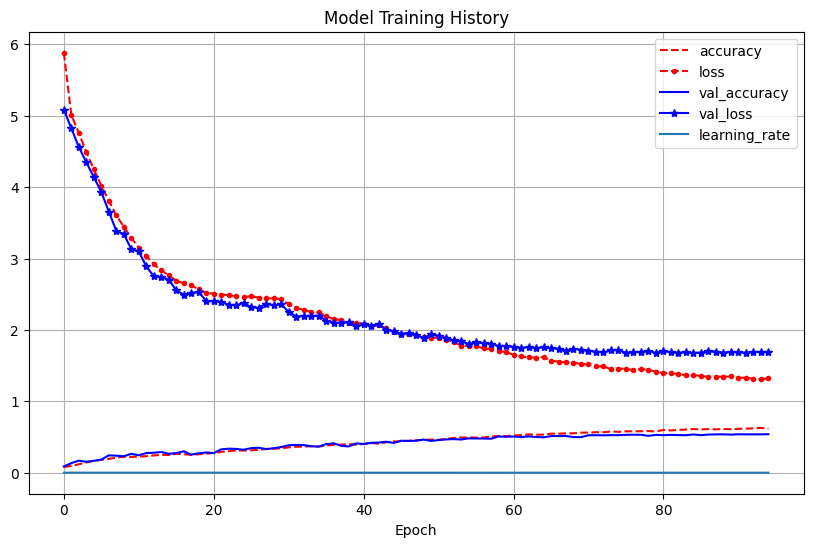

In [9]:
# define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-7, verbose=1)

# train model!!!
print("Training model...")
history = model.fit(train_padded, y_train_encoded, epochs=200, batch_size=32, validation_data=(val_padded, y_val_encoded), callbacks=[early_stopping, reduce_lr])
print("Training complete.")

# plot train/val accuracy/loss
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(10, 6), grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.title("Model Training History")
plt.show()

In [10]:
from sklearn.metrics import classification_report

val_probabilities = model.predict(val_padded)
y_pred_val = np.argmax(val_probabilities, axis=1)

print("First 10 Validation Predictions:")
print(y_pred_val[:10])
print("\nFirst 10 True Validation Labels:")
print(y_val_encoded[:10])

gesture_names_int = label_encoder.classes_
gesture_names_str = [str(name) for name in gesture_names_int]
report = classification_report(y_val_encoded, y_pred_val, target_names=gesture_names_str)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
First 10 Validation Predictions:
[ 0 16 14 11  9 16  7 10  0  1]

First 10 True Validation Labels:
[ 0 15 14 13  0  0  7  3  1  3]
              precision    recall  f1-score   support

           0       0.38      0.54      0.45       123
           1       0.29      0.22      0.25       127
           2       0.88      0.95      0.91        22
           3       0.31      0.17      0.22       121
           4       0.54      0.53      0.54       118
           5       0.90      0.86      0.88        22
           6       0.40      0.51      0.45       131
           7       0.50      0.67      0.57       122
           8       0.94      0.97      0.95        30
           9       0.35      0.39      0.37       121
          10       0.33      0.17      0.22       126
          11       0.30      0.93      0.45        27
          12       0.99      0.88      0.93        90
          13       0.71      0.13      0.22        39
          14      